In [1]:
import numpy as np
import pandas as pd

import os
import glob

In [2]:
# %matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue'], 
                 'serif': ['Helvetica Neue']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Generate plots of gating effects

In [3]:
test = pd.read_csv('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/23hr/C4.csv')
test.columns

Index(['HDR-T', 'FSC-A', 'SSC-A', 'CFP/VioBlue-A', 'PE-A', 'mKate/APC-A',
       'GFP/FITC-A', 'AH_perc_gate', 'mKate/APC-A_GMMgate'],
      dtype='object')

C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


C:\Users\geeze\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


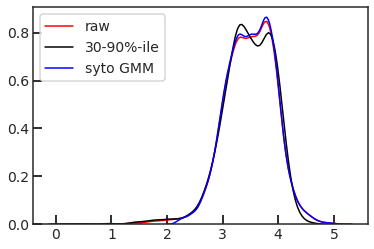

In [4]:
sns.kdeplot(test.loc[:, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['AH_perc_gate'] == 1, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['mKate/APC-A_GMMgate'] == 1, 'mKate/APC-A'].apply(np.log10))

plt.legend(labels=['raw', '30-90%-ile', 'syto GMM'])

### This is a work in progress, wanted to check first to see what we got and then move forward with analysis

## Plot fractions on and off in YFP channel over time

In [21]:
first = [i+j for i in ['A', 'B', 'C'] for j in ['1','2','3', '4', '5', '6', '7', '8', '9']]
second = [i+j for i in ['D', 'E', 'F', 'G', 'H'] for j in ['1','2','3', '4', '5', '6', '7', '8']]

#these are the only ones that all 4 tpts have in common due to incomplete 0hr sampling
wells_10 = first + second


#all 96 wells (common for 7, 19, 23 time points)
wells = [i+j for i in ['A','B','C','D','E','F','G','H'] for j in ['1','2','3','4','5','6','7','8','9','10','11','12']]

In [22]:
tpts = [0, 7, 19, 23]
t_last3 = [7, 19, 23]

In [23]:
gates = ['mKate/APC-A_GMMgate', 'AH_perc_gate']

In [104]:
def get_ratios_fracs (timepoints, well, gate):
    """
    gets the A:B ratio for each time point for a particular well, using the GMM analyzed data csv you made with
    Andy's analysis script.
    
    the timepoints argument is involved in making the filename to open, so if the location of your analyzed data
    changes, you'll need to edit this function
    """
    
    ratios = []
    f_ons = []
    f_offs = []
    for tpt in timepoints:
        ana = pd.read_csv('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/' + str(tpt) + 'hr/' + str(tpt) + 'hr_yfp_GMManalysis.csv')

        one = ana['well'] == well

        two = ana['gate'] == gate

        info = ana.loc[one & two, :]

        #OFF cells are A (BFP+), ON cells are B(YFP+). This division is A:B ratio
        ratio = info['fraction OFF'] / info['fraction ON']
        
        #let's also just get the fractions themselves
        frac_on = info['fraction ON']
        frac_off = info['fraction OFF']

        ratios.append(ratio.values[0])
        f_ons.append(frac_on.values[0])
        f_offs.append(frac_off.values[0])

    rs = pd.Series(data=ratios, index=timepoints, name='ratio')
    fons = pd.Series(data=f_ons, index=timepoints, name='frac_on')
    foffs = pd.Series(data=f_offs, index=timepoints, name='frac_off')
    
    #this has got to be the most convoluted way to create this df, but I'm committed
    #and don't understand enough to do it a better way
    df_collection = (pd.DataFrame([rs, fons, foffs]).assign(well=well)
                     .reset_index()
                     .rename(columns = {'index' : 'type'})
                    )
    
    
    
    return df_collection

In [116]:
z = get_ratios_fracs(tpts, 'C4', gates[0])
y = get_ratios_fracs(tpts, 'C5', gates[0])

In [117]:
z

,type,0,7,19,23,well
0,ratio,8.481308,43.000000,0.0,2.588139,C4
1,frac_on,0.105471,0.022727,1.0,0.278696,C4
2,frac_off,0.894529,0.977273,0.0,0.721304,C4


In [118]:
pd.melt(pd.concat([z,y]), id_vars=['well', 'type'], value_vars=[0, 7, 19, 23], var_name='Time (hr)')

,well,type,Time (hr),value
0,C4,ratio,0,8.481308
1,C4,frac_on,0,0.105471
2,C4,frac_off,0,0.894529
3,C5,ratio,0,10.386935
4,C5,frac_on,0,0.087820
5,C5,frac_off,0,0.912180
6,C4,ratio,7,43.000000
7,C4,frac_on,7,0.022727
8,C4,frac_off,7,0.977273
9,C5,ratio,7,0.000000


In [126]:
def tidy_ratios (timepoints, wells_list, gate):
    
    #transpose so each well is a column rather than a row
    all_ratios = pd.concat([get_ratios_fracs(timepoints, w, gate) for w in wells_list])
    
    #melt it tidy
    all_ratios = pd.melt(all_ratios, id_vars=['well', 'type'], value_vars=[0, 7, 19, 23], var_name='Time (hr)')
    
    return all_ratios.sort_values(by=['well', 'type'])

In [127]:
all_ratios = tidy_ratios(tpts, wells_10, gates[0])

C:\Users\geeze\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


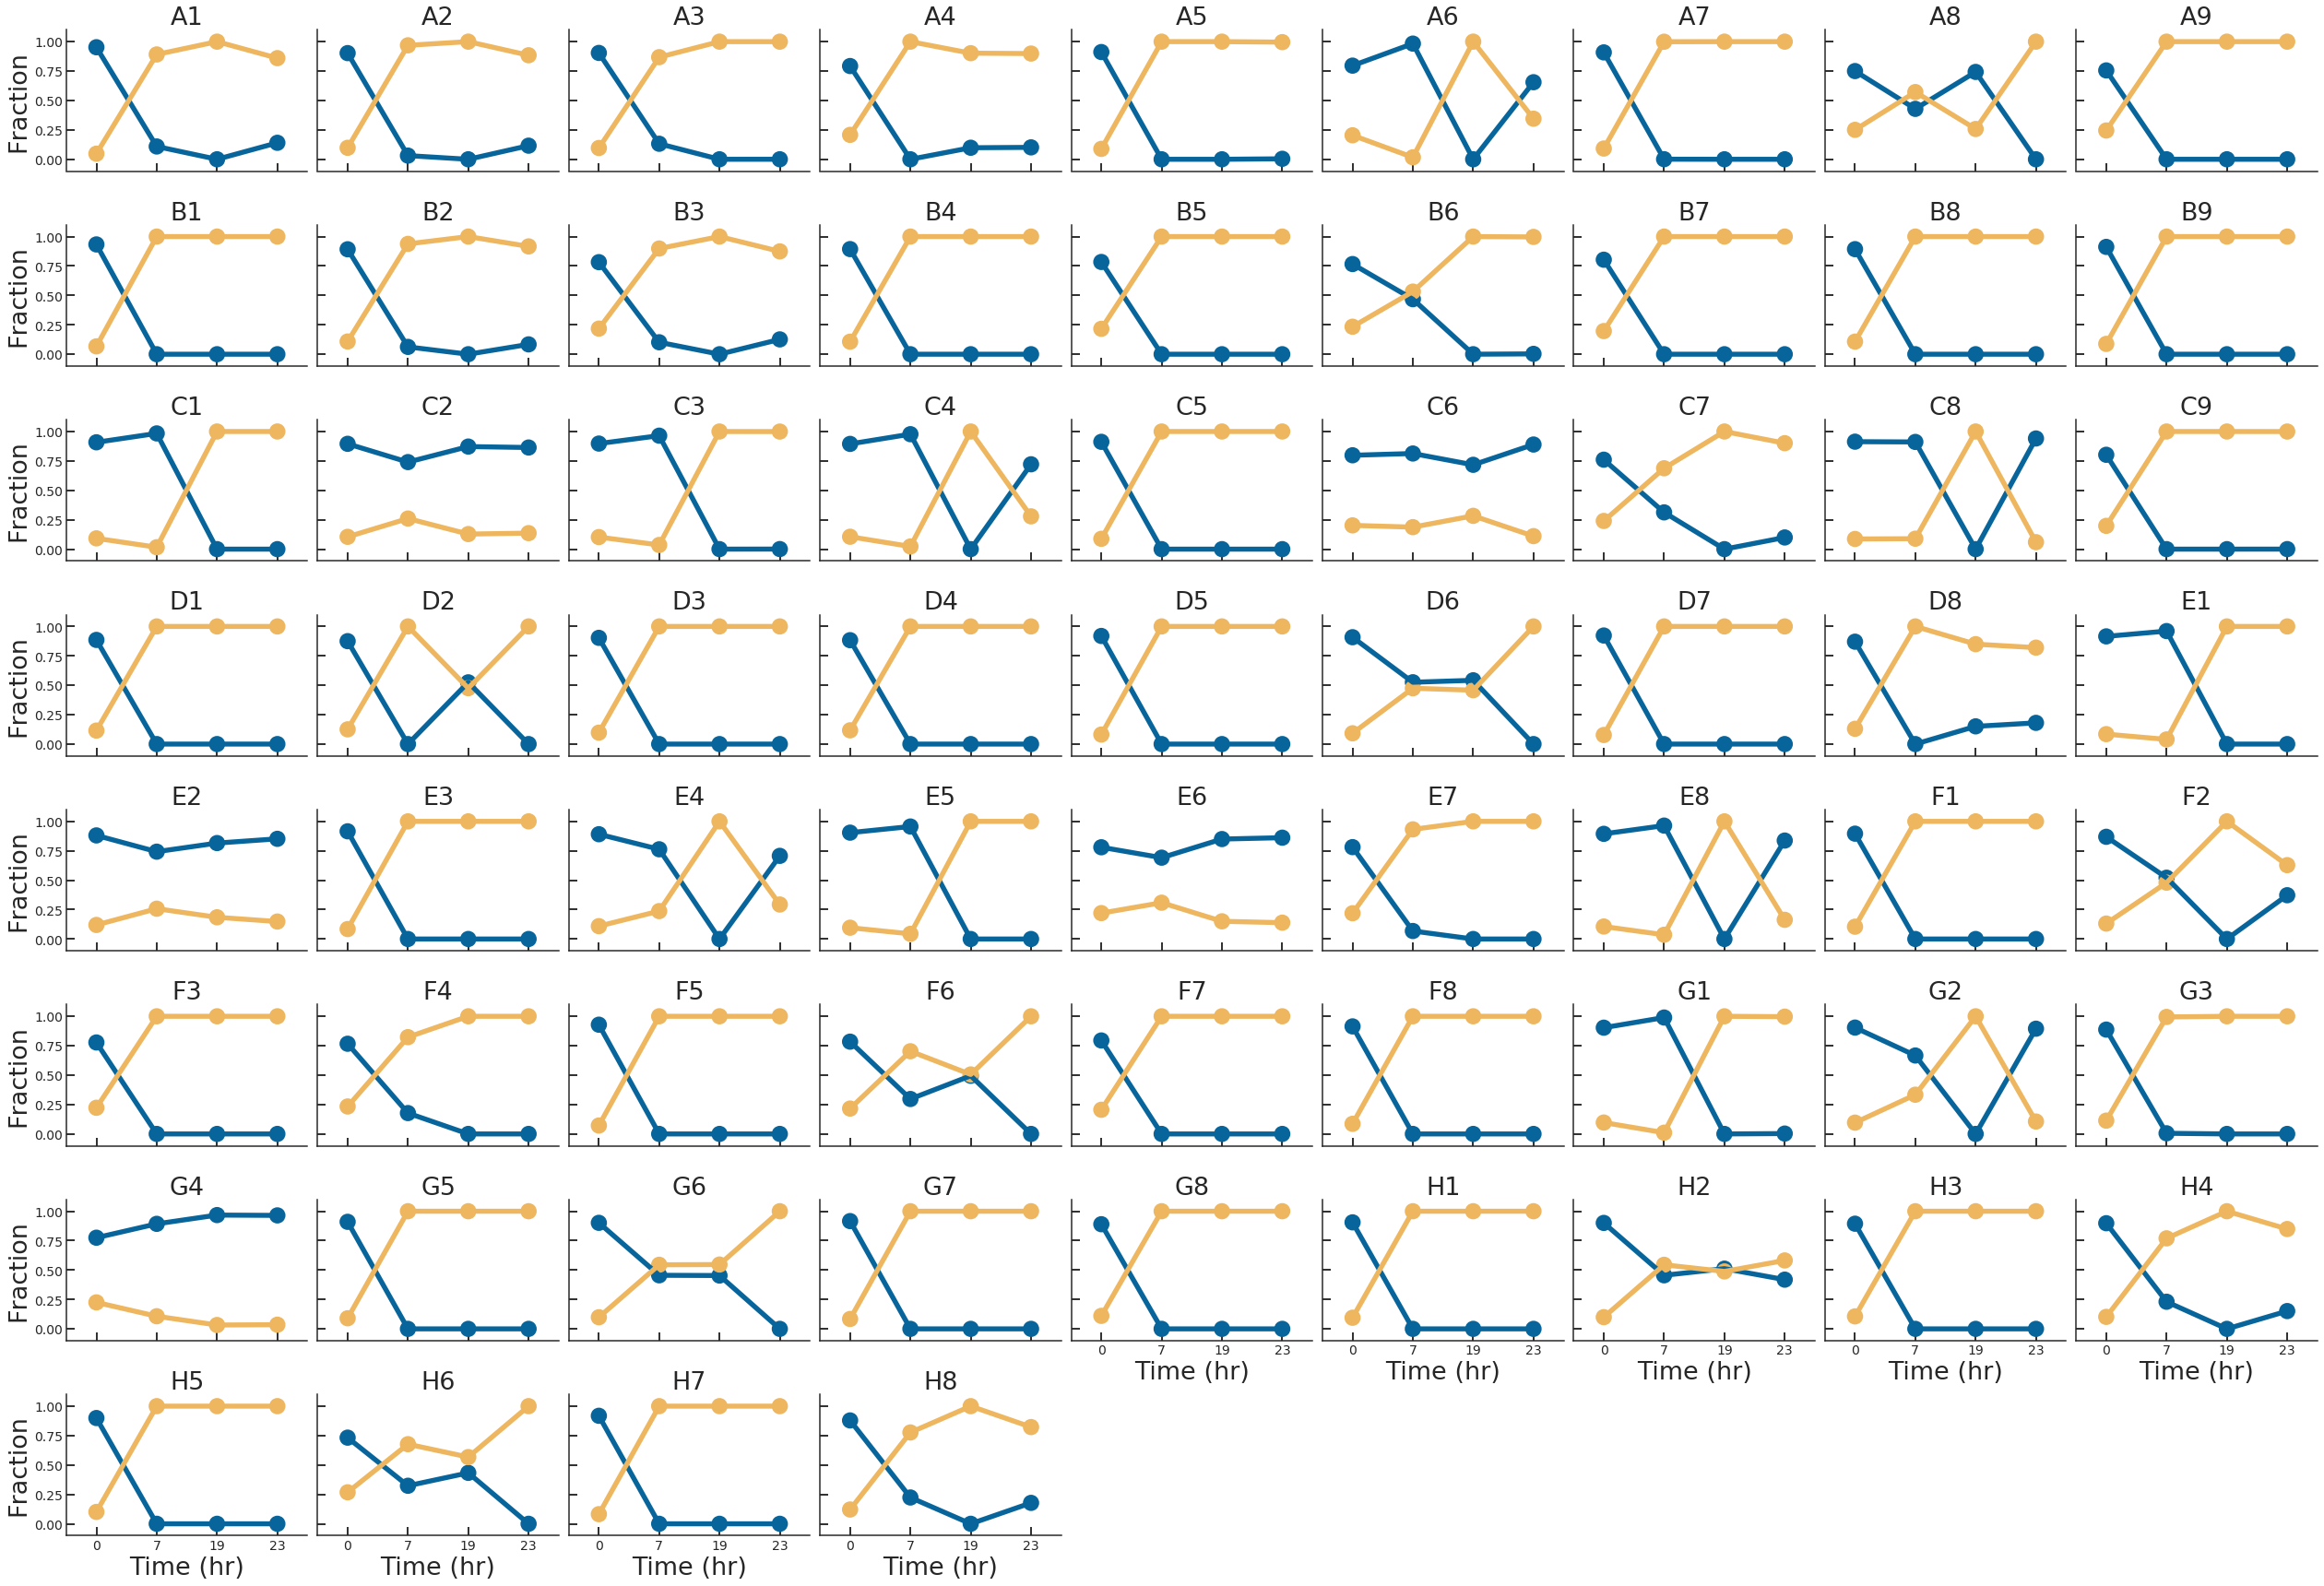

In [157]:
pal = dict(frac_on="#EDB65F", frac_off='#07659B')
g = sns.FacetGrid(all_ratios.loc[all_ratios['type'] != 'ratio'], col="well", hue='type', palette=pal,
                  col_wrap=9, height=3, aspect=1.3, ylim=(-0.1,1.1), margin_titles=True)


g.map(sns.pointplot, "Time (hr)", "value", ci=None, scale=2)

g.set_titles("{col_name}")
g.set_axis_labels('Time (hr)', "Fraction")
#g.set_titles("")

In [158]:
# g.fig.savefig('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/all_fracs_time_sytoGMMgate.pdf')